### Visualization of Global CO2 Emissions

The EDGAR Database (Emissions Database for Global Atmospheric Research) is a comprehensive source for emissions data.

Content of the Data: The EDGAR v8.0 dataset offers estimates of emissions for the three main greenhouse gases (CO2, CH4, N2O) and fluorinated gases, categorized by sectors and countries. For CO2 emissions, there are distinct figures for fossil and biogenic components. We utilize the gridmaps of total CO2 emissions with a resolution of 0.1x0.1° on a global level.

For the global maps, the most recent year included in the dataset (in this case, 2022) is visualized, while the analysis of the top and bottom 10 emitters uses the sum of emissions from 1970-2022.

Independent Estimates: The data in EDGAR are independent estimates compared to emissions reported by European member states or under the United Nations Framework Convention on Climate Change. They are based on international statistics and a consistent IPCC methodology.

Source: IEA-EDGAR CO2, a component of the EDGAR (Emissions Database for Global Atmospheric Research) Community Greenhouse Gas database Version 8.0 (2023), includes or is based on data from IEA (2022) Greenhouse Gas Emissions from Energy, www.iea.org/data-and-statistics, as modified by the Joint Research Centre. For download and more information: EDGAR Report 2023 (https://edgar.jrc.ec.europa.eu/report_2023)

In [1]:
#install and import libaries
import warnings
warnings.filterwarnings("ignore")

import re
import importlib
import os
from matplotlib.colors import LogNorm

# we need the shapefile to calculate emissions by country
relative_path_parts = ['Data', 'ne_10m_admin_0_countries', 'ne_10m_admin_0_countries.shp']
path_join = os.path.join(*relative_path_parts)
# absolute path
PATH_SHAPEFILE = os.path.abspath(path_join)

def install_and_import(modules):
    for module, alias in modules:
        try:
            if alias:
                globals()[alias] = importlib.import_module(module)
            else:
                globals()[module.split('.')[-1]] = importlib.import_module(module)
        except ImportError:
            %pip install {module}
            if alias:
                globals()[alias] = importlib.import_module(module)
            else:
                globals()[module.split('.')[-1]] = importlib.import_module(module)
    print("Hello World - all modules successfully imported!")

# List of libraries we need, if not installed yet, it will installed and imported
libraries = [
    ('numpy', 'np'),
    ('matplotlib.pyplot', 'plt'),
    ('matplotlib.colors', 'mcolors'),
    ('xarray', 'xr'),
    ('geopandas','gpd'),
    ('cartopy', None),
    ('cartopy.crs', 'ccrs'),
    ('pandas', 'pd'),
    ('rioxarray', None),
    ('zipfile', None),
    ('tempfile', None),
    ('tqdm', None),
    ('requests', None),
    ('plotly.express', 'px'),
    ('plotly.graph_objects', 'go')
    
]

install_and_import(libraries)




Hello World - all modules successfully imported!


Download Data via: https://edgar.jrc.ec.europa.eu/gallery?release=v80ghg&substance=CO2&sector=TOTALS or using the ftp server: 

In [2]:
# URL of the ZIP file
url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/EDGAR/datasets/v80_FT2022_GHG/CO2/TOTALS/TOTALS_emi_nc.zip"

# Local path for the ZIP file
relative_path_parts = ['Data', 'TOTALS_emi_nc.zip']
path_join = os.path.join(*relative_path_parts)
# absolute path
local_zip_path = os.path.abspath(path_join)

# Check if the ZIP file exists locally
if not os.path.exists(local_zip_path):
    # Download the ZIP file if it does not exist locally
    print("Downloading ZIP file...")
    response = requests.get(url, stream=True)
    with open(local_zip_path, 'wb') as file:
        for chunk in tqdm(response.iter_content(chunk_size=1024)):
            if chunk:
                file.write(chunk)


# Unzip the archive
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    temp_dir = tempfile.TemporaryDirectory()
    zip_ref.extractall(temp_dir.name)

# Extract year from file name and sort files by year
def extract_year_from_filename(filename):
    match = re.search(r"_\d{4}_", filename)
    return int(match.group(0)[1:-1]) if match else None

nc_files = [os.path.join(temp_dir.name, file) for file in os.listdir(temp_dir.name) if file.endswith('.nc')]
nc_files_sorted = sorted(nc_files, key=lambda x: extract_year_from_filename(x))

# Load .nc data in chronological order
ds_all = xr.open_mfdataset(nc_files_sorted, combine='nested', concat_dim='time', use_cftime=True)

# Assuming the files cover a continuous range of years, from start_year to end_year
start_year = extract_year_from_filename(nc_files_sorted[0])
end_year = extract_year_from_filename(nc_files_sorted[-1])
time_coord = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq='YS')

# Assign time coordinate to dataset
ds_all = ds_all.assign_coords(time=('time', time_coord))


In [3]:
ds_all

<xarray.Dataset>
Dimensions:    (lat: 1800, lon: 3600, time: 53)
Coordinates:
  * lat        (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon        (lon) float64 -179.9 -179.8 -179.8 -179.7 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 1970-01-01 1971-01-01 ... 2022-01-01
Data variables:
    emissions  (time, lat, lon) float32 dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes:
    institution:       European Commission, Joint Research Centre
    source:            https://edgar.jrc.ec.europa.eu/dataset_ghg80
    how_to_cite:       https://edgar.jrc.ec.europa.eu/dataset_ghg80#howtocite
    copyright_notice:  https://edgar.jrc.ec.europa.eu/dataset_ghg80#conditions
    contacts:          https://edgar.jrc.ec.europa.eu/dataset_ghg80#info JRC-...

### Extract relevant years and calculate difference

In [4]:
# choose 1990 and 2022
co2_1990 = ds_all.sel(time='1990-01-01')
co2_2022 = ds_all.sel(time='2022-01-01')

# extract emission data
emissions_1990 = co2_1990.variables['emissions'][:]
emissions_2022 = co2_2022.variables['emissions'][:]

# calculate difference most actual year minus base year
emissions_diff = emissions_2022 - emissions_1990

lat = ds_all.lat[:]
lon = ds_all.lon[:]
lon, lat = np.meshgrid(lon, lat)



### Plot CO2 emissions 2022

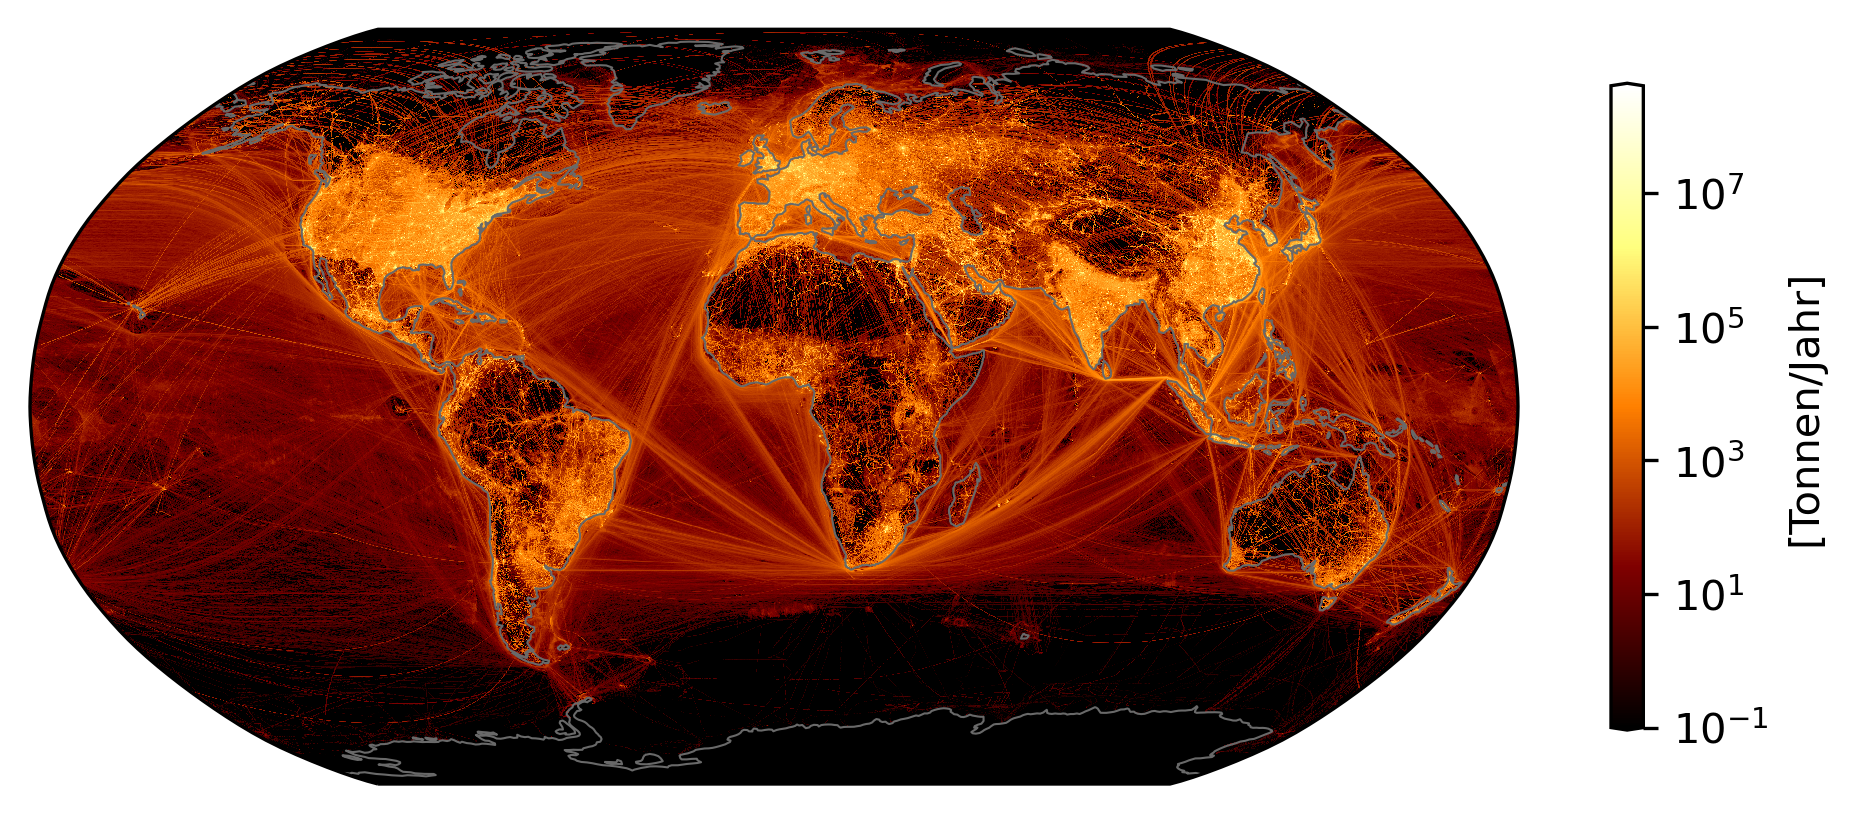

In [5]:
emissions_2022 = emissions_2022.compute()

fig, ax = plt.subplots(figsize=(8, 5.6),
    subplot_kw={'projection': ccrs.Robinson()},
    dpi=300
)
ax.patch.set_facecolor('black')
fig.patch.set_alpha(0) 
fig.patch.set_facecolor('none')  # Setzt den Figur-Hintergrund auf transparent

#logarithmic normalization
norm = LogNorm(vmin=max(emissions_2022.min(), 1e-1), vmax=emissions_2022.max())



# plot
mesh = ax.pcolormesh(lon, lat, emissions_2022, cmap='afmhot', norm=norm, transform=ccrs.PlateCarree())

# colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', extend='both', 
                    shrink=0.5, aspect=20,  #  Dicke anpassen
                    extendfrac='auto')  # Länge anpassen
cbar.set_label('[Tonnen/Jahr]', fontsize=10, color='black')


# coastlines
ax.coastlines(color='dimgray', linewidth=0.5)

plt.savefig('CO2_2022.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()



### Plot difference 2022 - 1990

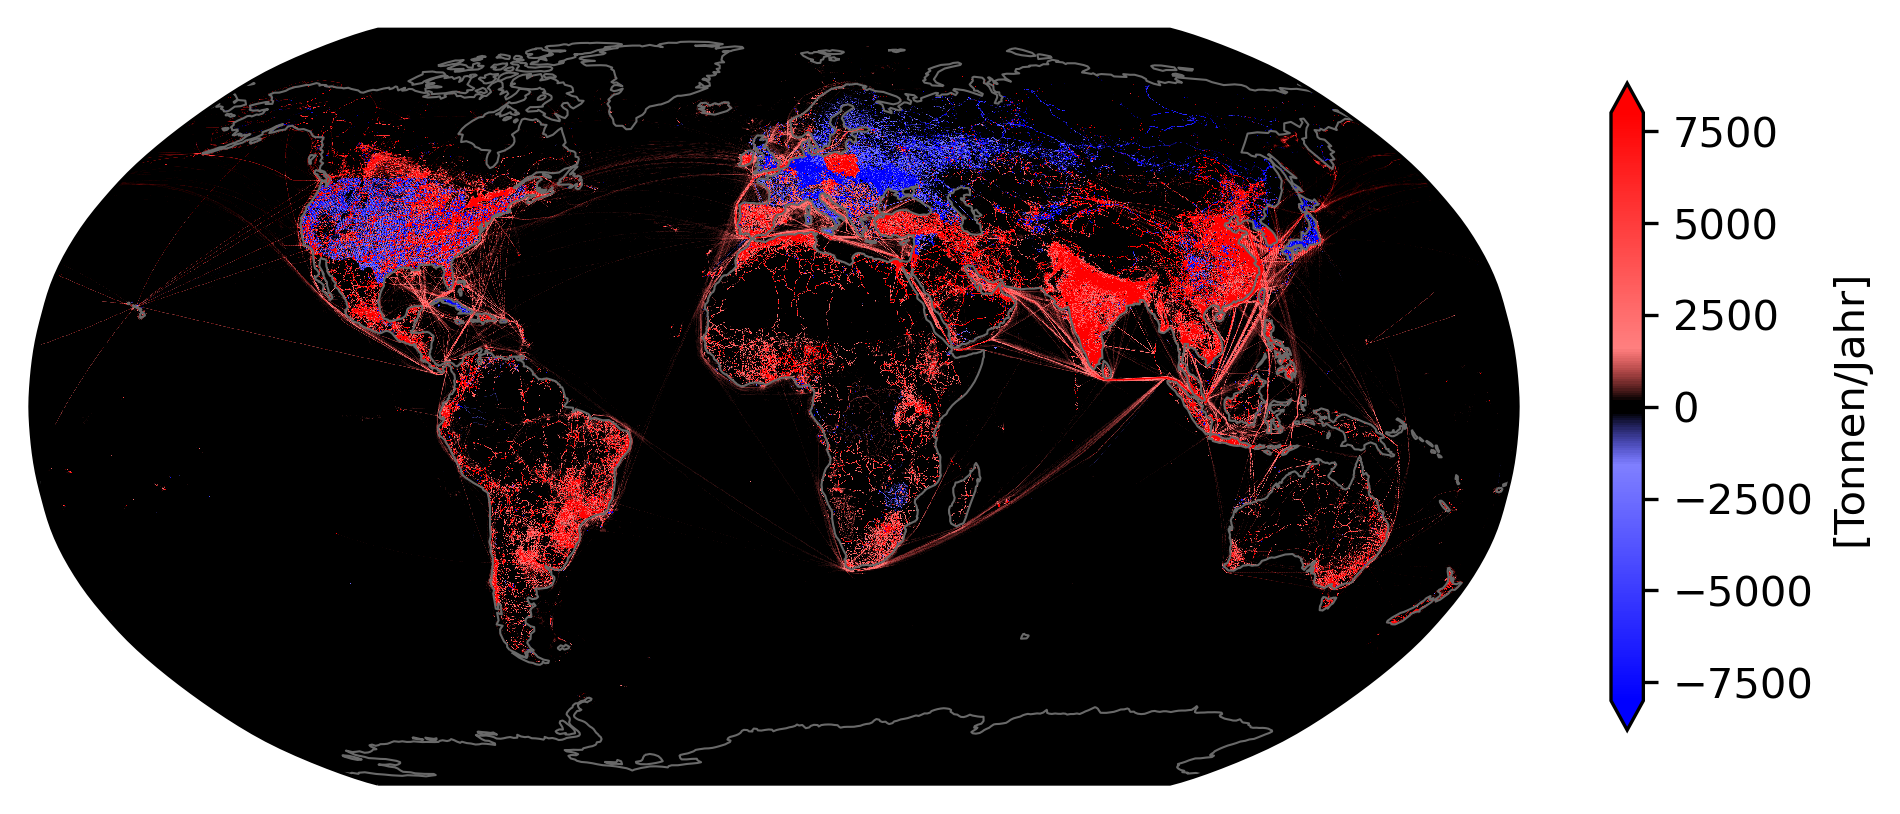

In [6]:
def make_colormap(seq):
    seq = [(None, *s) if len(s) == 2 else s for s in seq]
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    for pos, color, alpha in seq:
        r, g, b = mcolors.to_rgb(color)
        cdict['red'].append((pos, r, r))
        cdict['green'].append((pos, g, g))
        cdict['blue'].append((pos, b, b))
        cdict['alpha'].append((pos, alpha, alpha))
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

# define colormap
seq = [(0, 'blue', 1), (0.4, 'blue', 0.5), (0.49, 'black', 1), 
       (0.5, 'black', 1), (0.51, 'black', 1), (0.6, 'red', 0.5), 
       (1, 'red', 1)]

custom_cmap = make_colormap(seq)

# normalization
norm = mcolors.TwoSlopeNorm(vmin=-8000, vcenter=0, vmax=8000)


fig, ax = plt.subplots(figsize=(8, 5.6), subplot_kw={'projection': ccrs.Robinson()}, dpi=300)
fig.patch.set_alpha(0) 
# plot
mesh = ax.pcolormesh(lon, lat, emissions_diff, cmap=custom_cmap, norm=norm, transform=ccrs.PlateCarree())

# colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', extend='both', shrink=0.5)
cbar.set_label('[Tonnen/Jahr]', fontsize=10)

# coastlines and title
ax.coastlines(color='dimgray', linewidth=0.5)
#plt.title('CO2 Emissionen Differenz 2022 - 1990', fontsize=10)

#
plt.savefig('Diff_2022_1990.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()



### Load shapefile and aggregate data by country

In [7]:
#read shapefile
countries_gdf = gpd.read_file(PATH_SHAPEFILE)

# convert in rioxarray-object
emissions_rio = ds_all['emissions'].rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
emissions_rio.rio.write_crs("epsg:4326", inplace=True)

# spatial aggregation
country_emissions = {}
for index, row in countries_gdf.iterrows():
    country_name = row['NAME']
    country_geom = row['geometry']
    try:
        clipped = emissions_rio.rio.clip([country_geom], countries_gdf.crs)
        country_emissions[country_name] = clipped.sum(dim=['lat', 'lon'])
    except rioxarray.exceptions.NoDataInBounds:
        print(f"No data for {country_name}.")
 

No data for Sint Maarten.
No data for Monaco.
No data for USNB Guantanamo Bay.
No data for Brazilian I..
No data for Gibraltar.
No data for Vatican.
No data for Pitcairn Is..
No data for U.S. Minor Outlying Is..
No data for Montserrat.
No data for St-Barthélemy.
No data for Indian Ocean Ter..
No data for Br. Indian Ocean Ter..
No data for Tuvalu.
No data for Nauru.
No data for Coral Sea Is..
No data for Spratly Is..
No data for Clipperton I..
No data for Ashmore and Cartier Is..
No data for Bajo Nuevo Bank.
No data for Serranilla Bank.
No data for Scarborough Reef.


### Plot Top/Bottom 10 CO2-emittents

In [8]:

data = []
for country, emissions in country_emissions.items():
    # extract yearly emissions by country
    annual_emissions = emissions.values
    for year, emission in zip(range(1970, 2023), annual_emissions):
        data.append({'country': country, 'year': year, 'emission': emission})

# get dataframe
df_emissions = pd.DataFrame(data)

In [9]:

# sort data
top_10_emitters = df_emissions.groupby('country')['emission'].sum().nlargest(10)
bottom_10_emitters = df_emissions.groupby('country')['emission'].sum().nsmallest(10)

top_10_emitters = top_10_emitters.reset_index()
bottom_10_emitters = bottom_10_emitters.reset_index()

# plotly diagram for top 10 emittents
fig_top = px.bar(top_10_emitters, x='country', y='emission')
fig_top.update_yaxes(exponentformat='e')
fig_top.update_layout(
    title='Top 10 CO2-Emittenten (Summe 1970-2022)',
    xaxis_title='Jahr',
    yaxis_title='CO2-Emissionen (Tonnen)',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white',
    xaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5),
    yaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5, tickformat='.0e')
)
fig_top.update_xaxes(showline=True, linewidth=1, linecolor='grey')
fig_top.update_yaxes(showline=True, linewidth=1, linecolor='grey')

fig_top.show()

# plotly diagram for bottom 10 emittents
fig_bottom = px.bar(bottom_10_emitters, x='country', y='emission')
fig_bottom.update_layout(
    title='Bottom 10 CO2 Emittenten (Summe 1970 - 2022)',
    xaxis_title='Jahr',
    yaxis_title='CO2-Emissionen (Tonnen)',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white',
    xaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5),
    yaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5, tickformat='.0e')
)
fig_bottom.update_xaxes(showline=True, linewidth=1, linecolor='grey')
fig_bottom.update_yaxes(showline=True, linewidth=1, linecolor='grey')

fig_bottom.show()

In [10]:
def most_emissions(df):
    # Create an empty container for dropdown menu options
    item_list = []

    # Iterate over the rows (years) in the DataFrame
    for year in df.index:
        # Sort the DataFrame for the current year and select the top 10 countries
        df_sorted = df.loc[year].sort_values(ascending=False).head(10)

        # Create an entry for the dropdown menu
        item = dict(args=[{"y": [df_sorted.values], "x": [df_sorted.index]},
                          {"title": f"Top 10 CO2 Emitters in {year}"}],
                    label=str(year), method="update")
        item_list.append(item)

    # Create the initial chart
    first_year = df.index[0]
    first_viz = df.loc[first_year].sort_values(ascending=False).head(10)
    fig = px.bar(first_viz, y=first_viz.values, x=first_viz.index,
                 title=f"Top 10 CO2 Emitters in {first_year}")

    # Add the dropdown menu to the chart
    fig.update_layout(
        updatemenus=[
            dict(buttons=list(item_list),
                 direction="down", showactive=True, x=0.005,
                 xanchor="left", y=1.15, yanchor="top")
        ]
    )

    # Adjust the layout
    fig.update_layout(
        plot_bgcolor='black',  # Black background for the chart area
        paper_bgcolor='black',  # Black background for the entire figure
        font_color='white',  # White font color
        xaxis=dict(showgrid=True, gridcolor='darkgrey', gridwidth=0.5),  # Settings for the X-axis
        yaxis=dict(showgrid=True, gridcolor='darkgrey', gridwidth=0.5, tickformat='.0e', range=[0, 6e9])  # Settings for the Y-axis
    )

    fig.update_xaxes(showline=True, linewidth=1, linecolor='darkgrey')  # Lines for the X-axis
    fig.update_yaxes(showline=True, linewidth=1, linecolor='darkgrey')  # Lines for the Y-axis
    fig.update_xaxes(title_text='Country')  # Label for the X-axis
    fig.update_yaxes(title_text='CO2 Emissions (Tons)')  # Label for the Y-axis

    return fig

In [11]:
#create a dataframe
data = {}
for country, emissions in country_emissions.items():
    data[country] = emissions.to_pandas()

df_most = pd.DataFrame(data)
df_most
df_most.index = pd.to_datetime(df_most.index).year


In [12]:
df_most

,Indonesia,Malaysia,Chile,Bolivia,Peru,Argentina,Dhekelia,Cyprus,India,China,...,S. Geo. and the Is.,Falkland Is.,Vanuatu,Niue,American Samoa,Palau,Guam,N. Mariana Is.,Bahrain,Macao
time,,,,,,,,,,,,,,,,,,,,,
1970,26260558.0,12778880.0,23492102.0,3176275.0,14831674.0,85617472.0,8599.179688,1261797.250,2.120988e+08,9.016426e+08,...,3517.667236,11039.759766,65622.718750,0.123022,786.399231,1.077012e+06,32526.462891,627.617859,5.594522e+05,383140.0
1971,26520146.0,12855033.0,24698480.0,3923641.5,14855225.0,85927568.0,8594.830078,1276514.250,2.123013e+08,9.051738e+08,...,3517.667236,11038.640625,65633.109375,0.121408,786.755188,1.077250e+06,32560.962891,627.618835,5.613372e+05,391398.0
1972,31110666.0,12698102.0,25120424.0,4655323.0,14744909.0,87615832.0,9373.980469,1583730.000,2.203041e+08,9.652858e+08,...,3682.330566,11566.037109,71856.257812,0.118269,830.598450,1.077424e+06,34304.085938,663.729614,5.958331e+05,434027.0
1973,35255544.0,13164146.0,25012638.0,4366116.5,15907108.0,90904536.0,10302.200195,1667419.000,2.188727e+08,1.001895e+09,...,3891.253418,12316.653320,85786.484375,0.124290,869.065125,1.077700e+06,35619.070312,694.172119,6.471641e+05,492385.0
1974,39450100.0,14782214.0,23782448.0,4197521.0,16847824.0,91242728.0,7621.379883,1264885.750,2.342002e+08,1.015742e+09,...,3636.008057,11601.390625,101551.562500,0.119865,830.278076,1.077884e+06,34232.546875,663.821655,7.229901e+05,538412.0
1975,41067704.0,15412680.0,21401096.0,4739135.0,17471024.0,88701808.0,6577.200195,1362342.750,2.488856e+08,1.160959e+09,...,3390.348633,10878.603516,87413.359375,0.115708,795.655212,1.077756e+06,33085.117188,637.060791,1.073727e+06,501304.0
1976,43384216.0,16584264.0,21448654.0,5337829.0,17980770.0,93361032.0,6963.529785,1723417.500,2.660143e+08,1.208402e+09,...,3496.075195,11253.496094,87802.601562,0.116581,803.669189,1.078438e+06,33171.601562,642.073242,1.389412e+06,514497.0
1977,58226232.0,16545118.0,20954150.0,5125683.0,17825406.0,97284920.0,7412.870117,1823254.750,2.715982e+08,1.354213e+09,...,3494.226318,11544.968750,98128.492188,0.123795,854.521973,1.078547e+06,36073.750000,687.807190,1.708346e+06,574440.0
1978,68544144.0,18059346.0,21347212.0,5831396.0,17685050.0,96589512.0,8060.640137,1906397.250,2.674817e+08,1.527625e+09,...,3515.399170,11775.896484,94569.734375,0.114148,876.971191,1.072944e+06,37315.027344,708.455505,1.880920e+06,566885.0


### Plot Top 10 CO2 emittents per year 

In [13]:
fig = most_emissions(df_most.tail(25))
fig.show()


### Calculate and plot timeseries of yearly global mean emissions and yearly sum of Germany emissions

In [14]:
# global yearly mean
df_global_mean = df_emissions.groupby('year')['emission'].mean().reset_index()

# rename column
df_global_mean.rename(columns={'emission': 'global_mean_emission'}, inplace=True)

In [15]:
#choose  country
df_germany = df_emissions[df_emissions['country'] == 'Germany']
df_germany

,country,year,emission
2544,Germany,1970,1.068870e+09
2545,Germany,1971,1.063415e+09
2546,Germany,1972,1.091566e+09
2547,Germany,1973,1.141558e+09
2548,Germany,1974,1.108140e+09
2549,Germany,1975,1.049455e+09
2550,Germany,1976,1.112271e+09
2551,Germany,1977,1.092069e+09
2552,Germany,1978,1.130249e+09
2553,Germany,1979,1.178553e+09


In [16]:
#plot yearly emissions
fig = go.Figure()

fig.add_trace(go.Bar(x=df_germany['year'], y=df_germany['emission'], name='Emissionen Deutschland'))
fig.add_trace(go.Scatter(x=df_global_mean['year'], y=df_global_mean['global_mean_emission'], name='Globales Mittel'))
fig.update_yaxes(exponentformat='e')
fig.update_layout(
    title='CO2-Emissionen Deutschlands und globales Mittel',
    xaxis_title='Jahr',
    yaxis_title='CO2-Emissionen (Tonnen)',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white',
    xaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5),
    yaxis=dict(showgrid=True, gridcolor='grey', gridwidth=0.5, tickformat='.0e')
)
fig.update_xaxes(showline=True, linewidth=1, linecolor='grey')
fig.update_yaxes(showline=True, linewidth=1, linecolor='grey')

fig.show()
